# Лабораторная работы №3 "Сезонные модели"
## Импортирование библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels
from scipy import stats
from tabulate import tabulate
from itertools import product
import warnings
warnings.filterwarnings("ignore")

## Загрузка входных данных

In [3]:
dist = pd.read_csv('data/season.csv')
season = dist["liquor"].dropna()
season

0       480
1       467
2       514
3       505
4       534
       ... 
331    1776
332    1743
333    1728
334    1769
335    2431
Name: liquor, Length: 336, dtype: int64

## График процесса, его АКФ и ЧАКФ

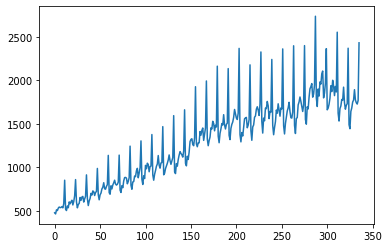

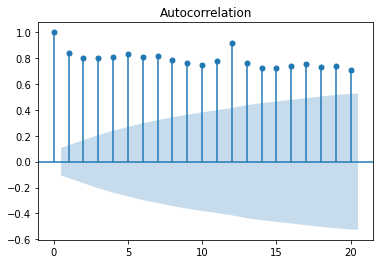

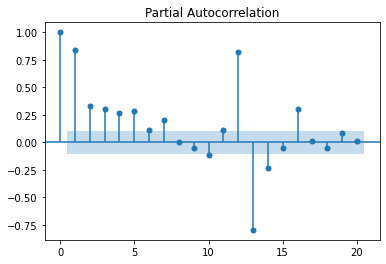

In [4]:
lagCount=20
plt.plot(season)
_ = plot_acf(season, lags=lagCount)
_ = plot_pacf(season, lags=lagCount)

## Удаление тренда

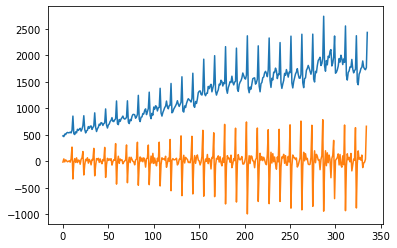

In [5]:
diff = list()
for i in range(1, len(season)):
	value = season[i] - season[i - 1]
	diff.append(value)
plt.plot(season, label='season')
plt.plot(diff, label='not trend')
plt.show()

## Разделение данных на обучающую и тестовую выборки

In [13]:
split_diff = int(len(diff) * 0.7)
diff_train, diff_test = diff[:split_diff], diff[split_diff:]

## График процесса, его АКФ и ЧАКФ без тренда

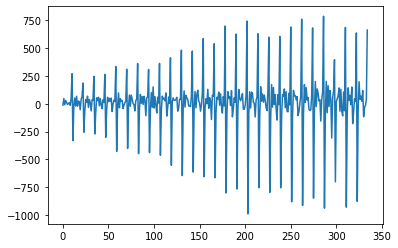

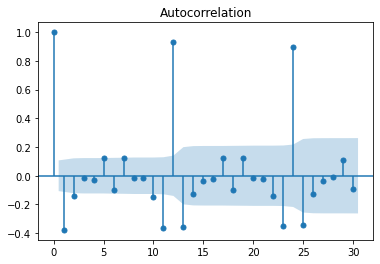

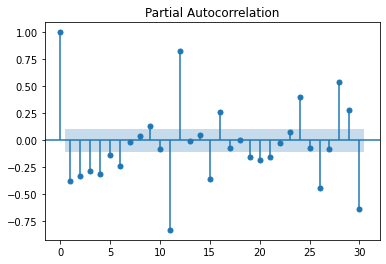

In [14]:
lagCountDiff = 30
plt.plot(diff)
_ = plot_acf(diff, lags=lagCountDiff)
_ = plot_pacf(diff, lags=lagCountDiff)

### Проанализируем графики АКФ и ЧАКФ, для определения максимальных порядков модели

### Проведём обучение для всех моделей, порядок которых ниже максимального порядка модели.

In [ ]:
pSeason = [0, 1, 2]
qSeason = [0, 1, 2]
pOrder  = [0, 1, 2]
qOrder  = [0, 1, 2]
models = {}

for i in pOrder:
    for j in qOrder:
        for k in pSeason:
            for l in qSeason:
                if ((i, j ,k, l) == (0, 0, 0, 0)):
                    continue
                arimax = SARIMAX(np.array(diff), order=(i, 0, j), seasonal_order=(k, 0, l, 12), initialization='approximate_diffuse').fit()
                pVal = arimax.pvalues
                if all(i <= 0.05 for i in pVal):
                    models[i, j, k, l] = arimax

### Количество моделей, имеющих значимые коэффициенты, то есть pVal < 0.05

In [ ]:
print(f'Количество моделей: {len(models.keys())}')

## Вычисление стандартной ошибки для моделей

In [7]:
def standard_error(y, y_1, order):
    return np.sqrt(np.sum(np.square((y_1 - y))) / (len(y) - order))

In [8]:
def standard_error_model(train, test, model):
    k = max(model.model_orders['ar'], model.model_orders['ma'])
    standard_error_train = standard_error(train, model.predict(len(train)), k)
    standard_error_test = standard_error(test, model.forecast(len(test)), k)
    return standard_error_train, standard_error_test

In [ ]:
m = {}

dict_se_train = {}
dict_se_test = {}
dict_aic = {}
dict_bic = {}
for name, model in models.items():
    tmp_dict = {}
    se_train, se_test = standard_error_model(season, diff, model)

    dict_se_train[name] = se_train
    dict_se_test[name] = se_test
    dict_aic[name] = model.aic
    dict_bic[name] = model.bic

    tmp_dict['SE Train'] = se_train
    tmp_dict['SE Test'] = se_test
    tmp_dict['AIC'] = model.aic
    tmp_dict['BIC'] = model.bic
    m[name] = tmp_dict

data = {
    'Model': list(m.keys()),
    'SE Train': list(dict_se_train.values()),
    'SE Test': list(dict_se_test.values()),
    'AIC': list(dict_aic.values()),
    'BIC': list(dict_bic.values())
}

df = pd.DataFrame.from_dict(data)
# df.set_index('Model')
dfAIC = df.sort_values("AIC")

## Таблица результатов моделей, отсортированных по критерию Акаике

In [ ]:
dfAIC.head(10)

## Анализ остатков моделей
### Отсортировав все модели по критерию акаике, выберем первые 5

### Построим их АКФ и ЧАКФ

In [ ]:
print(f'SARIMAX (2, 0, 1, 1)')
m = models[(2, 0, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (0, 1, 1, 1)')
m = models[(0, 1, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (0, 2, 1, 1)')
m = models[(0, 2, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (1, 2, 1, 1)')
m = models[(1, 2, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()

print(f'SARIMAX (1, 0, 1, 1)')
m = models[(1, 0, 1, 1)]
_ = plot_acf(m.resid)
_ = plot_pacf(m.resid)
plt.show()